<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#CLI" data-toc-modified-id="CLI-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>CLI</a></span><ul class="toc-item"><li><span><a href="#Nbdev" data-toc-modified-id="Nbdev-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Nbdev</a></span></li></ul></li></ul></div>

In [16]:
#export
import time
import numpy as np
import matplotlib.pyplot as plt
from cartesian_explorer import Explorer
import qtensor as qtn

In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
#export
ex = Explorer()

In [21]:
#export    
@ex.provider
def graph(N, d=3, graph_type='random', seed=10):
    return qtn.toolbox.random_graph(nodes=N, type=graph_type, degree=d, seed=seed)

In [71]:
#export
@ex.provider
def ansatz_circ(graph, p, composer_type='default'):
    gamma, beta = [.1]*p, [.3]*p
    if composer_type=='default':
        composer = qtn.DefaultQAOAComposer(graph, gamma=gamma, beta=beta)
    elif composer_type=='full':
        composer = qtn.OldQtreeQAOAComposer(graph, gamma=gamma, beta=beta)
    composer.ansatz_state()
    return tuple(composer.circuit)

@ex.provider
def qtensor_time(ansatz_circ, target_tw=24,
                 fail_tw=45,
                 qtn_ordering_algo='greedy',
                 batch_vars=0
                ):
    """
    Args:
        ansatz_circ (list): qtree circuit
        target_tw: slice until reached
        fail_tw: if initial tw is larger, fail
        qtn_ordering_algo: ordering algorithm
        batch_vars: log2 of number of amplitudes to simulate
    Returns:
        time to sample amplitude from 
    """
    optimizer = qtn.toolbox.get_ordering_algo(qtn_ordering_algo)
    
    
    
    sim = qtn.QtreeSimulator(optimizer=optimizer, max_tw=fail_tw)
    start = time.time()
    try:
        sim.simulate(ansatz_circ)
    except Exception as e:
        print('Exception:', e)
        return None
    end = time.time()
    return end - start


In [72]:
t = ex.get_variable('qtensor_time', N=10, p=2, fail_tw=20)
t

0.01485133171081543

In [50]:
#export
@ex.provider
def qtensor_tw(ansatz_circ, target_tw=24,
                 qtn_ordering_algo='greedy',
                 batch_vars=0
                ):
    """
    Args:
        ansatz_circ (list): qtree circuit
        target_tw: slice until reached
        qtn_ordering_algo: ordering algorithm
        batch_vars: log2 of number of amplitudes to simulate
    Returns:
        time to sample amplitude from 
    """
    optimizer = qtn.toolbox.get_ordering_algo(qtn_ordering_algo)
    tn = qtn.optimisation.TensorNet.QtreeTensorNet.from_qtree_gates(ansatz_circ)
    optimizer.optimize(tn)
    return optimizer.treewidth
    


Exception: Treewidth 27 is larger than max_tw=26.
Exception: Treewidth 33 is larger than max_tw=26.
Exception: Treewidth 47 is larger than max_tw=26.
Exception: Treewidth 54 is larger than max_tw=26.
Exception: Treewidth 57 is larger than max_tw=26.



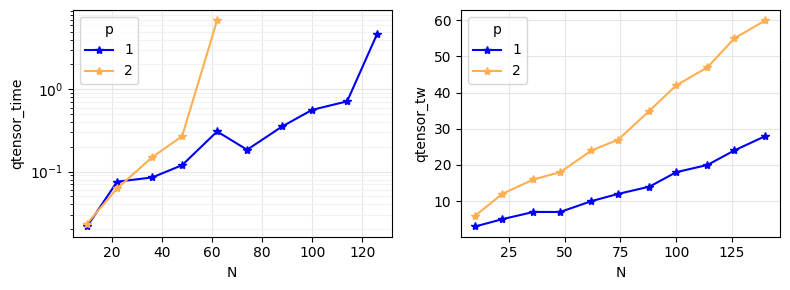

In [70]:
#Ns = 2*(.2*np.pi**(np.arange(0, 11)/2)).astype(np.int) + 6
Ns = 2*np.linspace(5, 70, 11, dtype=int)
def custom_plot(x, y, **kwargs):
    plt.plot(x, y, '*-', **kwargs)
    plt.yscale('log')
fig = ex.plot_variables(('qtensor_time','qtensor_tw'),
                        plot_func=custom_plot,
                        p=[1,2], N=Ns,
                        qtn_ordering_algo=['rgreedy_0.02_5'],
                        fail_tw=[26],
                       )
fig.axes[1].set_yscale('linear')

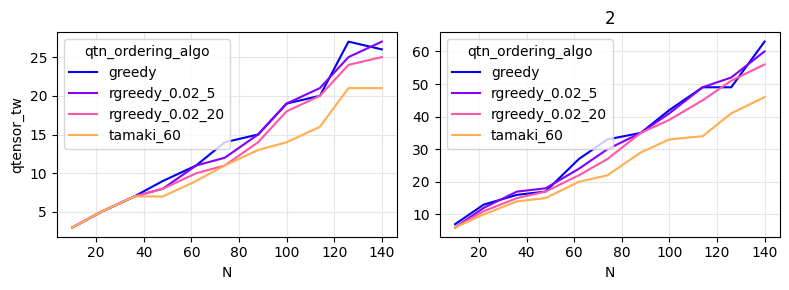

In [74]:
fig = ex.plot_variables(('qtensor_tw', ),
                        p=[1,2],
                        qtn_ordering_algo=['greedy', 'rgreedy_0.02_5', 'rgreedy_0.02_20', 'tamaki_60'],
                        N=Ns,
                       )
fig.axes[1].set_yscale('linear')

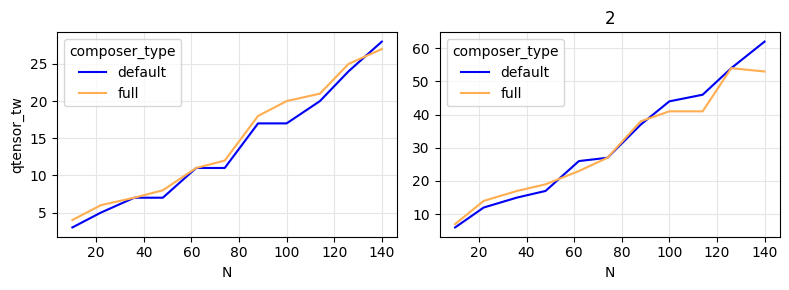

In [73]:
fig = ex.plot_variables(('qtensor_tw', ),
                        p=[1,2],
                        composer_type=['default', 'full'],
                        N=Ns,
                        qtn_ordering_algo=['rgreedy_0.02_5'],
                       )
fig.axes[1].set_yscale('linear')

In [ ]:
def gen_time_data(Ns, ps, **kwargs):
xar = ex.get_variables_xarray(
    ('qtensor_time', 'quimb_time'),
    p=ps,
    N=Ns,
    **kwargs,
)
return xar

## CLI

In [5]:
#export
from qtensor_specs import cli
import click

/home/dali/git-bulit/cotengra/cotengra/hyper.py:18: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn("Couldn't import `kahypar` - skipping from default "


In [12]:
#export
@cli.command()
@click.argument('filename')
@click.option('--n_len', default=4)
@click.option('--p_len', default=2)
@click.option('-O', '--qtn_ordering_algo', default='greedy')
@click.option('-N', '--n_processes', default=2)
@click.argument('filename')
def qaoa_ansatz_time(filename, n_len, p_len, **kwargs):
    Ns = 2*(.5*np.pi**(np.arange(0, 12)/2)).astype(np.int) + 10
    Ns = Ns[:n_len]
    ps = [2, 3, 4]
    ps = ps[:p_len]
    kwargs = {k:[v] for k, v in kwargs.items()}
    xar = gen_time_data(Ns, ps, **kwargs)
    xar.to_netcdf(filename)
    
    

### Nbdev

In [3]:
#hide
#default_exp qaoa_ansatz_complexity

from nbdev.export import *
notebook2script()

Converted QAOA_bench.ipynb.
Converted Speed_comparison.ipynb.
Converted Time_vs_FLOP.ipynb.
Converted index.ipynb.
Converted qaoa_ansatz_complexity.ipynb.
